In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ixi-t1/IXI175-HH-1570-T1.nii/IXI175-HH-1570-IXIMADisoTFE12_-s3T147_-0301-00003-000001-01.nii
/kaggle/input/ixi-t1/IXI280-HH-1860-T1.nii/IXI280-HH-1860-MADisoTFE1_-s3T176_-0301-00003-000001-01.nii
/kaggle/input/ixi-t1/IXI439-HH-2114-T1.nii/IXI439-HH-2114-MADisoTFE1_-s3T203_-0301-00003-000001-01.nii
/kaggle/input/ixi-t1/IXI035-IOP-0873-T1.nii/IXI035-IOP-0873-SAGFSPGR_-sIXI35_-0003-00001-000001-01.nii
/kaggle/input/ixi-t1/IXI429-Guys-0997-T1.nii/IXI429-Guys-0997-MPRAGESEN_-s419_-0301-00003-000001-01.nii
/kaggle/input/ixi-t1/IXI150-HH-1550-T1.nii/IXI150-HH-1550-IXIMADisoTFE12_-s3T145_-0301-00003-000001-01.nii
/kaggle/input/ixi-t1/IXI506-Guys-1035-T1.nii/IXI506-Guys-1035-MPRAGESEN_-s425_-0301-00003-000001-01.nii
/kaggle/input/ixi-t1/IXI643-HH-2787-T1.nii/IXI643-HH-2787-MADisoTFE1_-s3T253_-0301-00003-000001-01.nii
/kaggle/input/ixi-t1/IXI533-Guys-1066-T1.nii/IXI533-Guys-1066-MPRAGESEN_-s428_-0401-00004-000001-01.nii
/kaggle/input/ixi-t1/IXI490-Guys-1018-T1.nii/IXI490-Guys-1018-

In [21]:
!pip install torchio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 6.7 MB/s eta 0:00:00


/tmp/ipykernel_23/1846597934.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/resnet21d/pytorch/default/1/r2plus1d_mri_mo

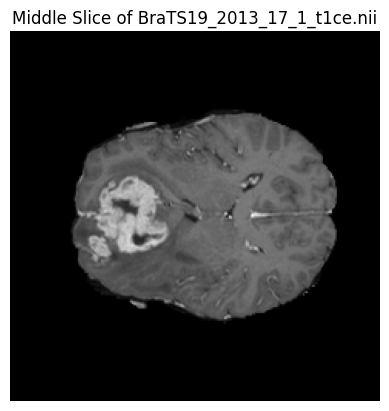

Predicted Class: Tumour
Probabilities: tensor([[0.2977, 0.6168, 0.0855]], device='cuda:0')


In [45]:
import torch
import torch.nn as nn
import nibabel as nib  # For MRI data handling
import numpy as np
import torchio as tio
import matplotlib.pyplot as plt

class R2Plus1dStem4MRI(nn.Module):
    def __init__(self, num_classes=3):  # 3 classes: HGG, LGG, Healthy
        super(R2Plus1dStem4MRI, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(1, 45, kernel_size=(1, 7, 7),
                      stride=(1, 2, 2), padding=(0, 3, 3), bias=False),
            nn.BatchNorm3d(45),
            nn.ReLU(inplace=True),

            nn.Conv3d(45, 64, kernel_size=(3, 1, 1),
                      stride=(1, 1, 1), padding=(1, 0, 0), bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True)
        )

        self.global_pool = nn.AdaptiveAvgPool3d(1)  # Global pooling
        self.fc = nn.Linear(64, num_classes)  # Fully connected for class scores

    def forward(self, x):
        x = self.stem(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = R2Plus1dStem4MRI(num_classes=3)
model.load_state_dict(torch.load('/kaggle/input/resnet21d/pytorch/default/1/r2plus1d_mri_model.pth', map_location=device))
model.to(device)
model.eval()

def preprocess_mri(image_path, transform):
    # Load the MRI data
    mri_data = nib.load(image_path).get_fdata()
    mri_data = np.expand_dims(mri_data, axis=0)  # Add channel dimension

    # Wrap the data in a torchio Subject and apply transformation
    subject = tio.Subject(t1=tio.ScalarImage(tensor=mri_data))
    transformed_subject = transform(subject)

    # Extract the tensor from the transformed subject
    mri_tensor = transformed_subject['t1'].data  # This is a 4D tensor now [1, depth, height, width]

    # Add a batch dimension (batch_size, channels, depth, height, width)
    mri_tensor = mri_tensor.unsqueeze(0)  # Adds a batch dimension to make it 5D

    mri_tensor = mri_tensor.to(torch.float32)
    
    return mri_tensor


# Perform manual testing
import nibabel as nib
import matplotlib.pyplot as plt

def test_model(image_path, transform):
    # Load MRI image
    mri_data = nib.load(image_path).get_fdata()
    
    # Display the middle slice of the image for visualization
    middle_slice_idx = mri_data.shape[2] // 2  # Middle slice in the 3rd dimension (z-axis)
    plt.imshow(mri_data[:, :, middle_slice_idx], cmap="gray")
    plt.title(f"Middle Slice of {image_path.split('/')[-1]}")
    plt.axis('off')  # Hide axes
    plt.show()

    input_tensor = preprocess_mri(image_path, transform).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)  # Get probabilities for each class
        prediction = torch.argmax(probabilities, dim=1).item()  # Get the predicted class
        sorted_probs, sorted_indices = torch.sort(probabilities, dim=1, descending=True)  # Sort the probabilities
        
        # Class names (order matters: 0: LGG, 1: HGG, 2: Healthy)
        class_names = ['Tumour', 'Tumour', 'Healthy']
        
        # Check if the highest or second highest probability corresponds to 'Healthy'
        if sorted_indices[0][0].item() == 2:
            print("Predicted Class: Healthy")
        elif sorted_indices[0][1].item() == 2:
            print("Predicted Class: Healthy")
        else:
            print(f"Predicted Class: {class_names[prediction]}")

        print(f"Probabilities: {probabilities}")



# Define the transformation (use the same one as during training)
transform = tio.CropOrPad(target_shape=(240, 240, 155))

test_image_path = '/kaggle/input/miccaibrats2019/MICCAI_BraTS_2019_Data_Training/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_17_1/BraTS19_2013_17_1_t1ce.nii'  # Replace with your MRI image path
test_model(test_image_path, transform)
